# **Cardiovascular Risk Fall 2023** 

1. *Objective*
Develop classification models using machine learning to assess the risk of cardiovascular diseases. This involves analyzing health indicators and clinical data to forecast cardiovascular issues.

2. *Data Description*
The dataset includes patient demographics (age, gender, etc.), clinical measurements (blood pressure, cholesterol levels, etc.), and historical health records.

3. *Evaluation Criteria*
Models will be evaluated on their accuracy on external test set

4. *Additional Information*
For more details and to access the data, visit the [Kaggle challenge page](https://www.kaggle.com/competitions/cardiovascular-disease-fall-2023).

5. *Leaderboard Ranking* **1st** with 0.735xx accuracy

## **Overview**
The analysis involves data preprocessing, exploratory data analysis, model building using LightGBM, and evaluation of model performance.

In [15]:
import pandas as pd
import lightgbm as lgb
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Load data

In [16]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample.csv')

## Feature Engineering

1. Hypertension Staging [link](https://www.ncbi.nlm.nih.gov/books/NBK539859/#:~:text=Elevated%3A%20SBP%20120%20to%20129,equal%20to%2090%20mm%20Hg.) 
2. Interaction terms amongst categorical variables
3. Natural log of Ages (due to skewness)
4. Interaction term b/w age and blood pressure
5. Body Mass Index (Ideas from others)
6. Removing original features

In [17]:
def hypertension_staging(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 0 # for normal group
    elif 120 <= row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 1 # for elevated group
    elif 130 <= row['ap_hi'] < 140 or 80 <= row['ap_lo'] < 90:
        return 2 # for stage 1 Hypertension group
    elif row['ap_hi'] >= 140 or row['ap_lo'] >= 90:
        return 3 # for stage 2 Hypertension group
    else:
        return 4 # Severe group

def engineer_features(df):
    # Convert number of days into years and apply natural log (ln(Age), yrs)
    df["ln_age"] = np.log(df["age"] / 365.0)  # Because the age is highly skewed

    df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)  # Compute Body-Mass Index (BMI, kg/m^2)
    df['ln_age_bP'] = df['ln_age'] * df['ap_hi']            # Age and Blood Pressure Interaction Term
    df['chol_gluc'] = df['cholesterol'] * df['gluc']        # Cholesterol + glucose Interaction Term
    df['alc_smoke'] = df['smoke'] * df['alco']              # Alcohol + smoke Interaction Term
    df['htn'] = df.apply(hypertension_staging, axis=1)      # Hypertension Stage
    df['htn_smoke'] = df['htn'] * df['smoke']               # Hypertension + smoke Interaction Term

    return df

def drop_original_features(df, features_to_remove=['age', 'weight', 'height', 'smoke', 'alco', 'gluc']):
    df = df.drop(columns=features_to_remove, errors='ignore')
    return df

# Function to extract feature names from OneHotEncoder
def get_feature_names(column_transformer, input_features):
    feature_names = []

    for transformer in column_transformer.transformers_:
        trans_name = transformer[0]
        trans = transformer[1]
        cols = transformer[2]

        if trans_name == 'remainder':
            # if remainder is a passthrough, we append the feature names directly
            if trans == 'passthrough':
                feature_names.extend(cols)
        elif hasattr(trans, 'get_feature_names_out'):
            # if a transformer has 'get_feature_names_out' method, use it
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            # otherwise, just append the original feature name
            feature_names.extend(cols)

    return feature_names

In [18]:
train = engineer_features(train)
train = drop_original_features(train)

# Assuming 'data' is your DataFrame and 'cardio' is the target
X = train.drop('cardio', axis=1)
y = train['cardio']

# Define categorical features
categorical_features = ['gender', 'cholesterol', 'active', 'chol_gluc', 'htn', 'htn_smoke', 'alc_smoke']

continuous_features = ['ap_hi', 'ap_lo', 'bmi', 'ln_age', 'ln_age_bP']

# Create a column transformer with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('cont', StandardScaler(), continuous_features)
    ],
    remainder='passthrough'  # Apply OneHotEncoder to categorical_features and leave the rest unchanged
)

# Apply the transformations to the training and validation sets
X_train_transformed = preprocessor.fit_transform(X)

# Get feature names
feature_names = get_feature_names(preprocessor, X.columns)

## Grid Search with Stratified K Fold

To find the best parameter combinations, un-comment below and run it

In [19]:
# param_grid = {
#     'num_leaves': [31, 51],
#     'min_data_in_leaf': [30, 100, 300],
#     'lambda_l1': [0, 0.5],
#     'lambda_l2': [0, 0.5]
# }

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gsearch = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, 
#                        scoring='accuracy', cv=skf, verbose=0, n_jobs=-1)

# gsearch.fit(X_train_transformed, y)

# print("Best parameters found: ", gsearch.best_params_)
# print("Best accuracy found: ", gsearch.best_score_)

# best_params = gsearch.best_params_

#### Best parameters are provided directly here 

In [20]:
best_params = {
    'lambda_l1': 0,
    'lambda_l2': 0.5,
    'min_data_in_leaf': 100,
    'num_leaves': 31
}
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train_transformed, y)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


LGBMClassifier(lambda_l1=0, lambda_l2=0.5, min_data_in_leaf=100)

### Visualizing Feature Importance

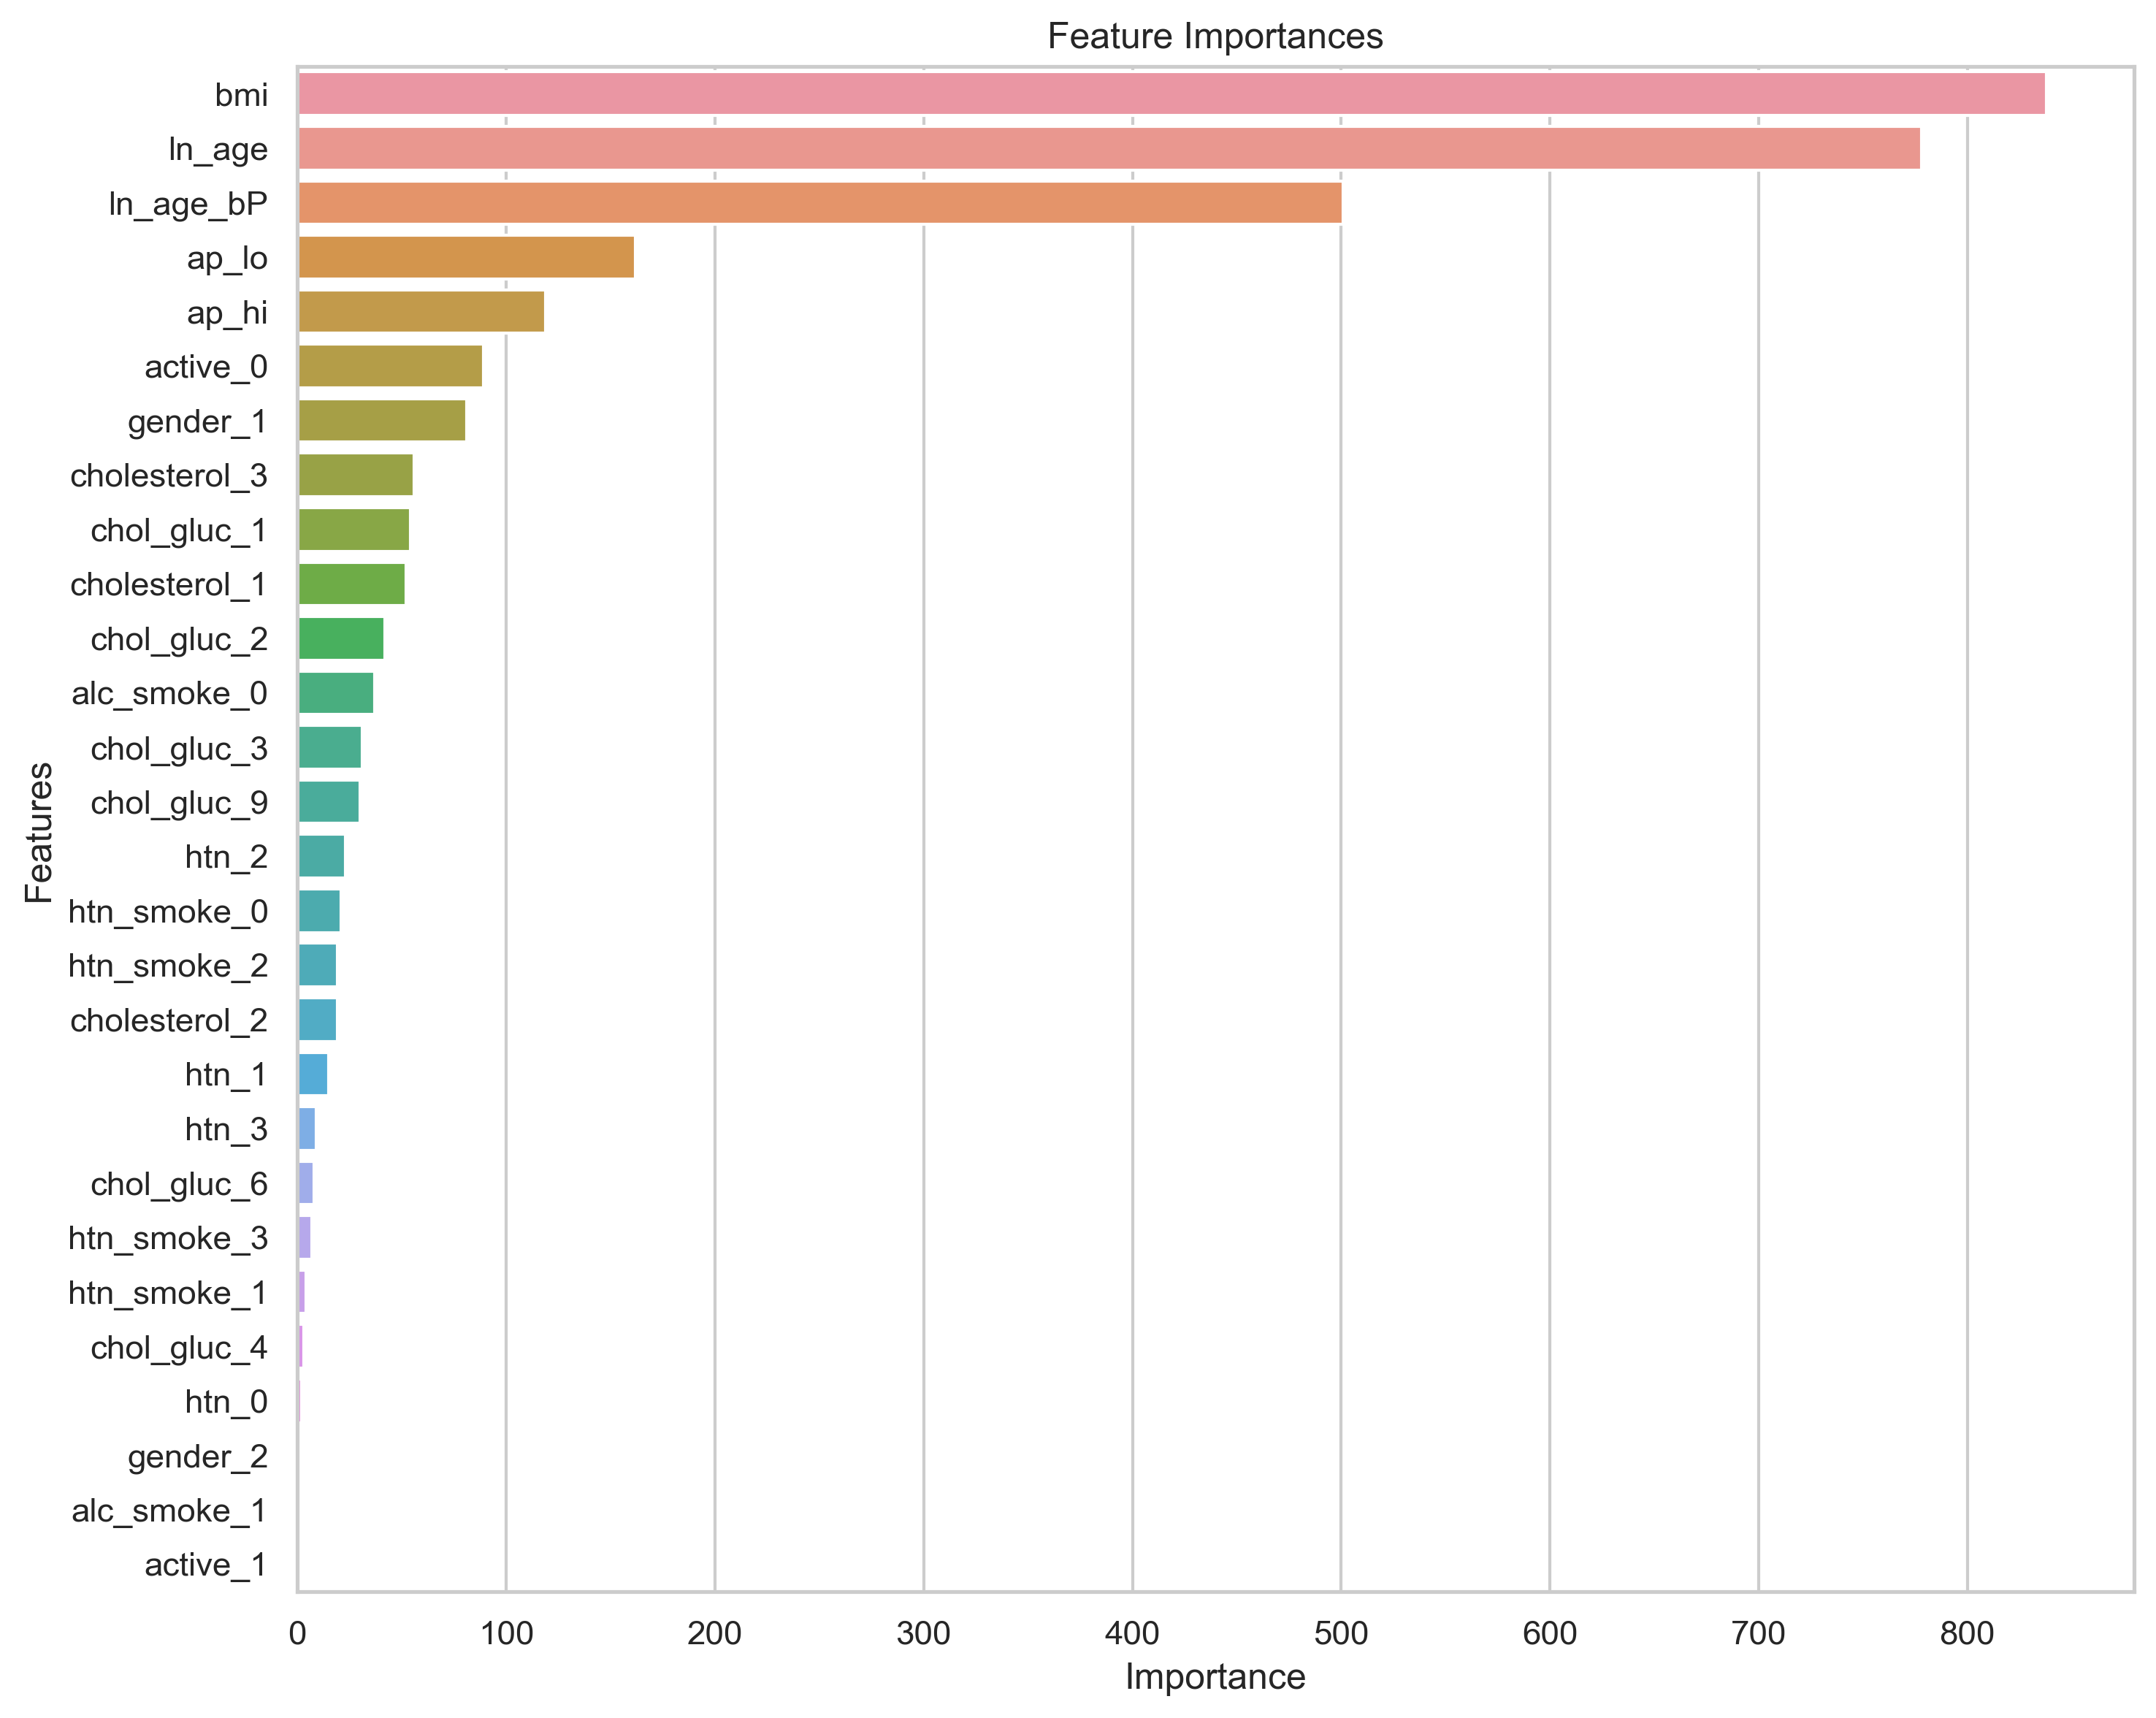

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain split feature importance
split_importance = model.feature_importances_

# Display feature importance with feature names
split_importance_df = pd.DataFrame({'Feature': feature_names, 'Split': split_importance})

# Sort the DataFrame by importance
split_importance_df_sorted = split_importance_df.sort_values(by='Split', ascending=False)

plt.figure(figsize=(10, 8), dpi=300)  # Set the figure size
sns.barplot(x="Split", y="Feature", data=split_importance_df_sorted)

plt.title('Feature Importances')  # Add a title
plt.xlabel('Importance')  # X-axis Label
plt.ylabel('Features')  # Y-axis Label

# Optional: Add gridlines and tweak aesthetics
sns.set(style="whitegrid")
plt.tight_layout()

# Show the plot
plt.show()

The top 3 features with the largest feature importance measured by 'split' are engineered features.  \
As you can see with the top 3 highest features being 1. *bmi* (838) 2. *ln_age* (778) 3. *ln_age_bP* (501) \
*gender_2*, *alc_smoke_1*, *active_1* had feature importance of 0. Since they are binary anyways, they did not have to be one-hot encoded. 

In [22]:
split_importance_df_sorted.head()

,Feature,Split
25,bmi,838
26,ln_age,778
27,ln_age_bP,501
24,ap_lo,162
23,ap_hi,119


### Generate Predictions

In [23]:
test = engineer_features(test)
test = drop_original_features(test)

# List of categorical and continuous feature
categorical_features = ['gender', 'cholesterol', 'active', 'chol_gluc', 'htn', 'htn_smoke', 'alc_smoke']
continuous_features = ['ap_hi', 'ap_lo', 'bmi', 'ln_age', 'ln_age_bP']

# Build the preprocessing pipeline
preprocessing = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('cont', StandardScaler(), continuous_features)
    ],
    remainder='passthrough'  # keep other features unchanged
)

# Apply transformations
X_processed_test = preprocessing.fit_transform(test)

predictions = model.predict(X_processed_test)

### Create Submission

In [24]:
submit = pd.DataFrame({'id':submission['id'], 'cardio':predictions})

submit.to_csv('./predictions_LGBM.csv',index=False)
print('Submitted Successfully')

Submitted Successfully


## **Discussions**

#### **How to further improve the prediction accuracy?** Removing confounders, reducing multicolinearities, check for domain shifts between train and test dataset

#### **Clinical Implications** Many more interaction terms could have been explored. But how many and why? What do they mean? 

#### **Why LGBM?** It's actually first time using LGBM for me. I saw Lonnie's Notebook and LGBM sounded super cool (with high score). Also, after quick search LGBM is faster than XGBoost, then why not exploit GridSearchCV to optimize hyperparameters? 

#### **So how effective was feature engineering?** More extended experiments can be throughly done to directly examine added contribution of engineered features and/or removing original features. It is not extensively investigated as my model merely would have benefited from the GridSearch and StratifiedKFold, rather than new features.  